The goal here is to develop a system for automatic playlist continuation given data on numerous existing playlists. The dataset is the Million Playlist Dataset from Spotify. The data consists of 1000 json files, each containing a 1000 playlists. Due to computational constraints, I will limit the data to 50 files (50000 playlists) chosen at random. The first objective is to read the files and build a dataframe that maps playlists to the songs/tracks. 

In [663]:
import os
import numpy as np
import pandas as pd
import json

from tqdm import tqdm
import heapq
import pprint as pp
from sklearn import metrics, datasets

from sklearn.preprocessing import PolynomialFeatures

import matplotlib
import matplotlib.pyplot as plt
import random
from scipy.sparse import dok_matrix
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors


# Data compilation

In [664]:
#Number of json files to use for this analysis. Each file has 1000 playlists
NumToParse = 50
jsonpath = "C:/users/kbijjula/Documents/Python/AI-course/Module-24/"

In [665]:
#functions to be used in code below

#function to parse uri
def parseURI(uri):
    return uri.split(":")[2]

#Create Sparse matrix mapping tracks and playlists
def Sparse_PL_track(playlists, tracks):
    # List of all track IDs
    trackIDs = list(tracks["tid"])

    # Map track id to matrix index
    IDtoIDX = {k:v for k,v in zip(trackIDs,range(0,len(trackIDs)))}
    
    playlistIDs = list(playlists["pid"])

    print("Create sparse matrix mapping playlists to tracks")
    SparsePlaylistTrack = dok_matrix((len(playlistIDs), len(trackIDs)), dtype=np.float32)

    for i in tqdm(range(len(playlistIDs)),position=0, leave=True):
        # Get playlist and track ids from DF
        playlistID = playlistIDs[i]

        trackID = playlists.loc[playlists.index[playlists['pid'] == playlistID][0]]["tracks"]

        playlistIDX = playlists.index[playlists['pid'] == playlistID][0]
        
        # Get matrix index for track id
        trackIDX = [IDtoIDX.get(i) for i in trackID]
        
        SparsePlaylistTrack[playlistIDX, trackIDX] = 1 

    return SparsePlaylistTrack.tocsr(), IDtoIDX

In [666]:
#Function to build the dataframe that maps playlists to tracks for a given set of json files
def build_dataframe(numFiles, path, jsonsamplefiles):

    files = jsonsamplefiles

    tracks_in_PL = set()
    playlist_list = []
    track_list = []

    print("Creating track and playlist DFs")
    for i, FILE in enumerate(tqdm(files,position=0, leave=True)):

        # get full path to file
        name = path + FILE 
        with open(name) as f:
            data = json.load(f)
            playlists = data["playlists"]

            for playlist in playlists:
                for track in playlist["tracks"]:
                    if track["track_uri"] not in tracks_in_PL:
                        tracks_in_PL.add(track["track_uri"])
                        track_list.append(track)
                playlist["tracks"] = [parseURI(x["track_uri"]) for x in playlist["tracks"]]
                playlist_list.append(playlist)


    playlistDF = pd.DataFrame(playlist_list)

    tracksDF = pd.DataFrame(track_list)

    # Remove spotify text from URI
    tracksDF["tid"] = tracksDF.apply(lambda row: parseURI(row["track_uri"]), axis=1)
          
    SparseDF, IDtoIDXMap = Sparse_PL_track(playlists=playlistDF, tracks=tracksDF)

    # Add sparseID 
    tracksDF["sparse_id"] = tracksDF.apply(lambda row: IDtoIDXMap[row["tid"]], axis=1)
    tracksDF = tracksDF.set_index("tid")
    
    return playlistDF, tracksDF, SparseDF

In [667]:
"""
Pick random files to be used in the analysis
"""
#random number generator
np.random.seed(seed = 1)
numbers = np.arange(0,1000,1)
sample = np.random.choice(numbers, size=NumToParse, replace=True)

print(sample)
#list all files in the json directory
jsonfiles = os.listdir("C:/users/kbijjula/Documents/Python/AI-course/Module-24/mpd/data")


#get sample files    
sample_files = [''] * NumToParse
for number in range(NumToParse):
    sample_files[number] = jsonfiles[sample[number]]

Allplaylists, Alltracks, SparsePL = build_dataframe(numFiles=NumToParse,
    path=jsonpath+"mpd/data/",
    jsonsamplefiles=sample_files)

print(f"Working with {len(Allplaylists)} playlists " + f"and {len(Alltracks)} songs")

[ 37 235 908  72 767 905 715 645 847 960 144 129 972 583 749 508 390 281
 178 276 254 357 914 468 907 252 490 668 925 398 562 580 215 983 753 503
 478 864  86 141 393   7 319 829 534 313 513 896 316 209]
Creating track and playlist DFs


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.44it/s]


Create sparse matrix mapping playlists to tracks


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1529.27it/s]


Working with 50000 playlists and 467839 songs


# Exploratory Data Analysis

***Artists with the most number of tracks in the selected playlists***

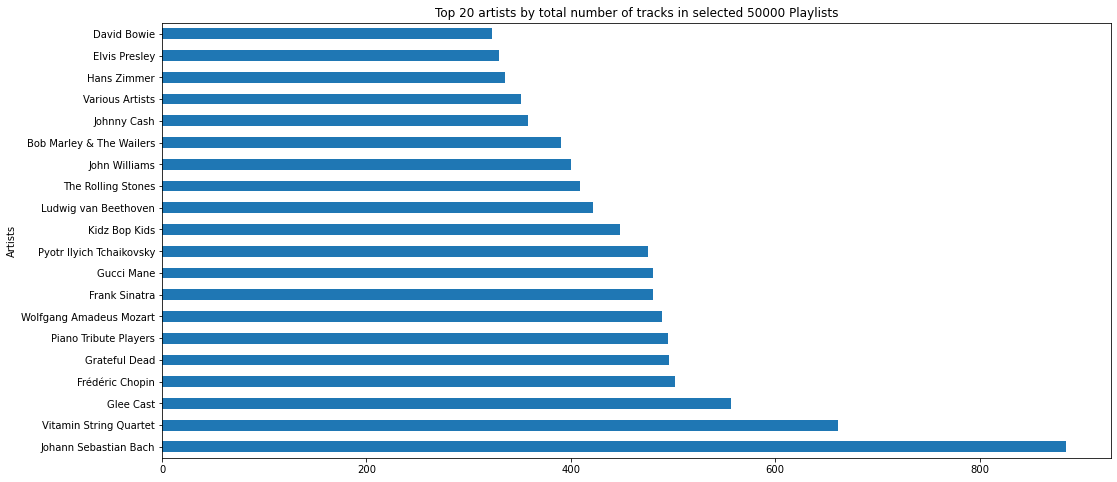

In [655]:
fig, ax = plt.subplots(figsize=(17,8))
plt.title("Top 20 artists by total number of tracks in selected 50000 Playlists")
Alltracks.artist_name.value_counts().head(20).plot(ax=ax, kind='barh', xlabel='Artists', ylabel='Total Number of tracks')
plt.show()

***Artists that occur in the most number of playlists in the selected playlists***

In [593]:
artistsbyPL = {}
for PLindex, PLrow in Allplaylists.iterrows():
    for trackID in PLrow['tracks']:
        artist_in_PL = Alltracks.loc[trackID]['artist_name']
        if artist_in_PL in artistsbyPL: 
            artistsbyPL[artist_in_PL] += 1
        else: 
            artistsbyPL[artist_in_PL] = 1
artistsbyPLdf=pd.DataFrame(artistsbyPL.items(), columns=['artist_name', 'Num_of_playlists'])
sortedartistsbyPLdf = artistsbyPLdf.sort_values(by=['Num_of_playlists'],ascending=False,ignore_index=True)
Top20sortedartistsbyPLdf=sortedartistsbyPLdf.head(20)

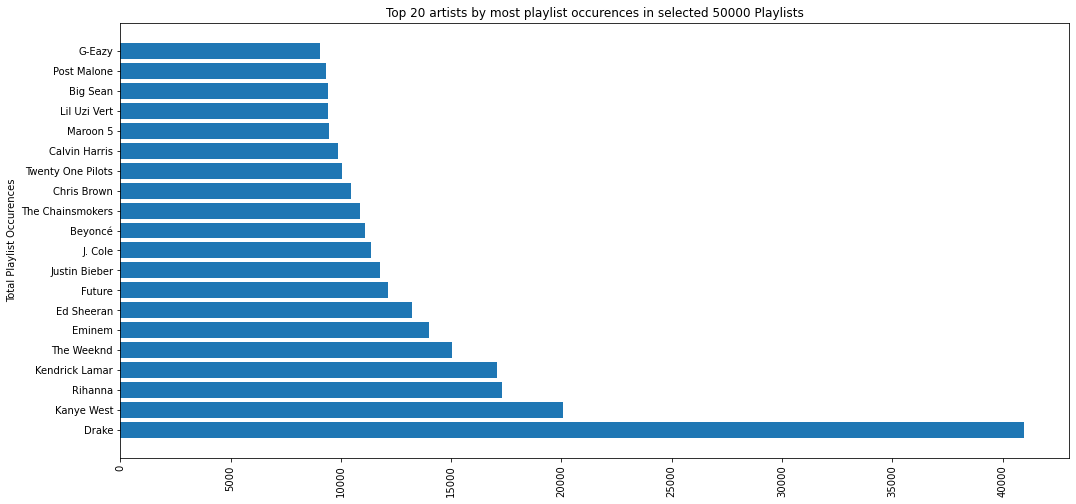

In [660]:
fig, ax = plt.subplots(figsize=(17,8))
plt.barh(Top20sortedartistsbyPLdf['artist_name'], Top20sortedartistsbyPLdf['Num_of_playlists'])
plt.title("Top 20 artists by most playlist occurences in selected 50000 Playlists")
plt.ylabel("Total Playlist Occurences")
plt.xticks(rotation='vertical')
plt.show()

***Most popular track***

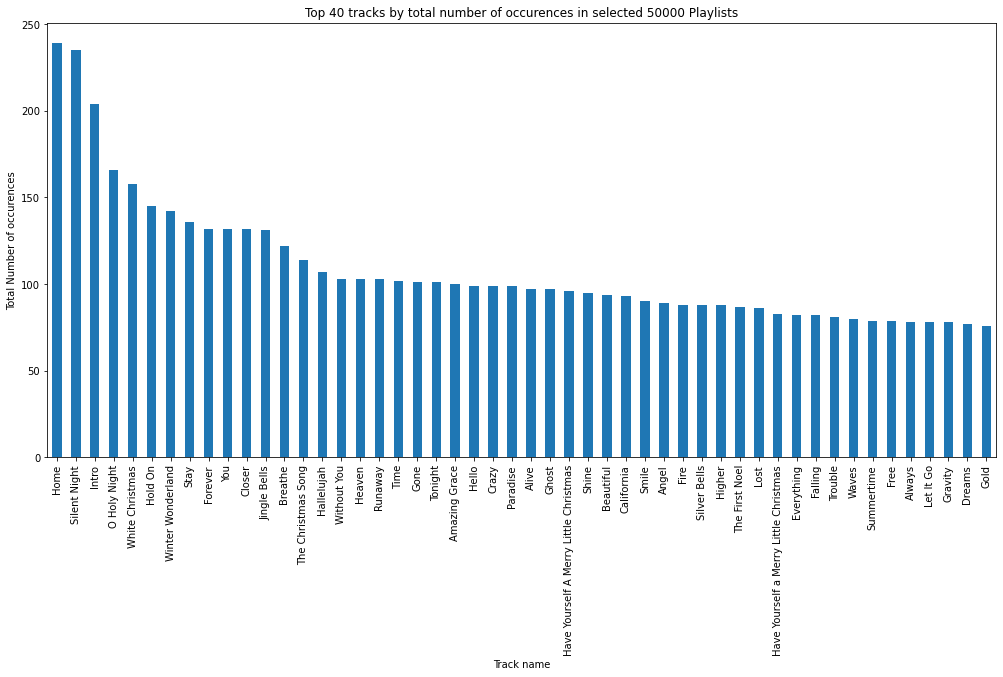

In [595]:
fig, ax = plt.subplots(figsize=(17,8))
plt.title("Top 40 tracks by total number of occurences in selected 50000 Playlists")
Alltracks.track_name.value_counts().head(50).plot(ax=ax, kind='bar', xlabel='Track name', ylabel='Total Number of occurences')
plt.show()

***Number of tracks in a playlist***

(array([14912., 12100.,  7735.,  4767.,  3443.,  2225.,  1814.,  1273.,
         1035.,   696.]),
 array([  5. ,  29.5,  54. ,  78.5, 103. , 127.5, 152. , 176.5, 201. ,
        225.5, 250. ]),
 <BarContainer object of 10 artists>)

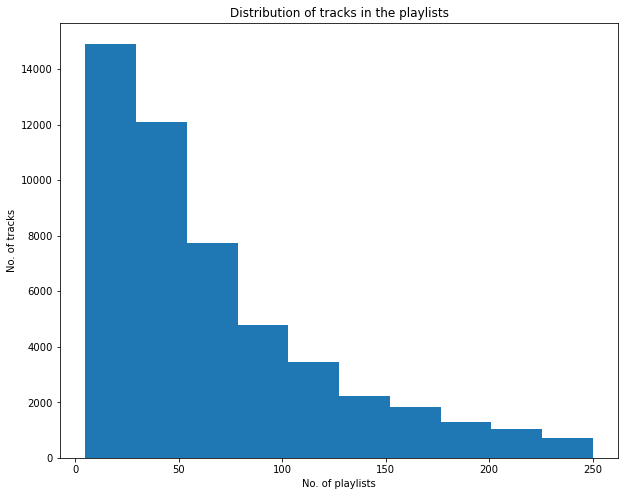

In [661]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("Distribution of tracks in the playlists")
plt.ylabel("No. of tracks")
plt.xlabel("No. of playlists")
plt.hist(Allplaylists.num_tracks)

# Select playlists for testing

From the remaining 950 json files, one file is chosen at random and 30 playlists will be selected to be the testing dataset. Training is done on the originally sampled 50000 playlists. A check is done to make sure that all the tracks in the test dataset exists in the training dataset. For the 30 playlists, 50% of the songs will be obscured. Based on the remiaing 50% of the songs, predictions will be made and the predictions will be compared to the full non-obscured playlist.

In [668]:
testplaylist_list = []
Testalltracks = list(Alltracks.index.values)


while (len(testplaylist_list) < 30):
    res = random.choice(list(set(range(0, len(jsonfiles)-1))-set(sample)))
    testfilename = jsonpath + "mpd/data/" + jsonfiles[res]
    with open(testfilename) as fname:
            data = json.load(fname)
            testplaylists = data["playlists"]
            # for each playlist
            for testplaylist in testplaylists:
                testplaylist["tracks"] = [parseURI(x["track_uri"]) for x in testplaylist["tracks"]]
                if set(testplaylist["tracks"]).issubset(set(Testalltracks)):
                    testplaylist_list.append(testplaylist)
                if len(testplaylist_list)>=30:
                    break
            else:
                continue
print('number of test playlists:',len(testplaylist_list))

testplaylistDF = pd.DataFrame(testplaylist_list)

number of test playlists: 30


# Models

***Baseline (popularity) model***

In [669]:
def obscurePlaylist(playlist, obscurity): 
    k = int(len(playlist['tracks']) * obscurity)
    indices = random.sample(range(len(playlist['tracks'])), k)

    obscured = [playlist['tracks'][i] for i in indices]
    tracks = [i for i in playlist['tracks'] + obscured if i not in playlist['tracks'] or i not in obscured]
    return tracks, obscured
    
def baselinepredictNeighbour(playlist, numPredictions, songs):
    return baselinepredict(playlist, numPredictions, songs)

In [670]:
def baselinegetPopularity():
    popularity = defaultdict(int)
    for playlist in Allplaylists['tracks']: 
        for track in playlist:
            popularity[track] += 1
    return popularity
        
def baselinepredict(playlist, numPredictions, songs, k=0):
    scores = heapq.nlargest(numPredictions, baselinegetPopularity(), key=baselinegetPopularity().get) 
    # scores = [songs.loc[x]['track_name'] for x in scores]
#    print(scores)
    return scores
    
    

In [671]:
def evalAccuracy(numPlaylists, percentToObscure=0.5):
    print()
    print(f"Selecting {numPlaylists} playlists to test and obscuring {int(percentToObscure * 100)}% of songs")

    def getAcc(FILE,pToObscure):
        playlist = FILE

        keptTracks, obscured = obscurePlaylist(playlist, pToObscure)
        playlistSub = playlist.copy()
        obscured = set(obscured)
        playlistSub['tracks'] = keptTracks

        predictions = baselinepredictNeighbour(playlistSub, 500, Alltracks)

        overlap = [value for value in predictions if value in obscured]
        return len(overlap)/len(obscured)

    accuracies=0
    for i, FILE in enumerate(tqdm(testplaylist_list,position=0, leave=True)):
        accuracies=accuracies+getAcc(FILE,percentToObscure)

    avgAcc = round(accuracies/30*100, 2)
    print(f"Using baseline classifier, we predicted {avgAcc}% of obscured tracks")
    return avgAcc

In [672]:
Baseline_acc = evalAccuracy(30)


Selecting 30 playlists to test and obscuring 50% of songs


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:57<00:00,  1.91s/it]

Using baseline classifier, we predicted 21.52% of obscured tracks


***Nearest Neighbor Classifier***

In [673]:

def getPlaylistsFromNeighbors(neighbours, pid):
    """
    """
    neighbours = list(filter(lambda x: x != pid, neighbours))
    return [Allplaylists.loc[x] for x in neighbours]

def getPlaylistTracks(playlist, songs):
    return [songs.loc[x] for x in playlist["tracks"]]

def getPredictionsFromTracks(tracks, numPredictions, pTracks):
    """
    """
    pTracks = set(pTracks)
    songs = defaultdict(int)
    for i, playlist in enumerate(tracks): 
        for song in playlist:
            track_uri = song['track_uri'].split(":")[2]
            if track_uri not in pTracks:
                songs[track_uri] += (1/(i+1))
    scores = heapq.nlargest(numPredictions, songs, key=songs.get) 
    return scores
    # return list(predictedSet)

def playlistToSparseMatrixEntry(playlist, songs):
    """
    Converts a playlist with list of songs
    into a sparse matrix with just one row
    """
    # print(songs.iloc[1:5])
    playlistMtrx = dok_matrix((1, len(songs)))
    tracks = [songs.loc[str(x)]["sparse_id"] for x in list(playlist["tracks"])]
    playlistMtrx[0, tracks] = 1
    return playlistMtrx.tocsr()

def NNpredict(playlist, numPredictions, songs, numNeighbours):
    model = NearestNeighbors(n_neighbors=60, metric='cosine')
#    print(f"Training Nearest Neighbors classifier")
    model.fit(SparsePL)
    pid, pTracks = playlist["pid"], playlist["tracks"]
    sparseX = playlistToSparseMatrixEntry(playlist, songs)
    neighbors = model.kneighbors(X=sparseX, return_distance=False, n_neighbors=numNeighbours)[0]
    playlists = getPlaylistsFromNeighbors(neighbors, pid)
    tracks = [getPlaylistTracks(x, songs) for x in playlists]
    predictions = getPredictionsFromTracks(tracks, numPredictions, pTracks)
    return predictions

In [674]:
def NNevalAccuracy(numPlaylists, nneighbors, percentToObscure=0.5):
    print()
    print(f"Training Nearest Neighbors classifier")

    def NNgetAcc(FILE,pToObscure):
        playlist = FILE

        keptTracks, obscured = obscurePlaylist(playlist, pToObscure)
        playlistSub = playlist.copy()
        obscured = set(obscured)
        playlistSub['tracks'] = keptTracks

        predictions = NNpredict(playlistSub, 500, Alltracks, nneighbors)

        overlap = [value for value in predictions if value in obscured]
        return len(overlap)/len(obscured)

    accuracies=0
    for i, FILE in enumerate(tqdm(testplaylist_list, position=0, leave=True)):
        accuracies=accuracies+NNgetAcc(FILE,percentToObscure)

    avgAcc = round(accuracies/30*100, 2)
    print(f"Using NN classifier, we predicted {avgAcc}% of obscured tracks when neighbors = {nneighbors}")
    return avgAcc

In [675]:
NNacc = []
for i in range(1,60,2):
    NNacc.append(NNevalAccuracy(30, i))


Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]


Using NN classifier, we predicted 16.04% of obscured tracks when neighbors = 1

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.79it/s]


Using NN classifier, we predicted 32.18% of obscured tracks when neighbors = 3

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.74it/s]


Using NN classifier, we predicted 35.79% of obscured tracks when neighbors = 5

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.59it/s]


Using NN classifier, we predicted 41.16% of obscured tracks when neighbors = 7

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.47it/s]


Using NN classifier, we predicted 48.26% of obscured tracks when neighbors = 9

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.37it/s]


Using NN classifier, we predicted 50.31% of obscured tracks when neighbors = 11

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.32it/s]


Using NN classifier, we predicted 54.38% of obscured tracks when neighbors = 13

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.14it/s]


Using NN classifier, we predicted 56.53% of obscured tracks when neighbors = 15

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.14it/s]


Using NN classifier, we predicted 53.55% of obscured tracks when neighbors = 17

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.04it/s]


Using NN classifier, we predicted 58.56% of obscured tracks when neighbors = 19

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.33it/s]


Using NN classifier, we predicted 56.75% of obscured tracks when neighbors = 21

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.88it/s]


Using NN classifier, we predicted 61.81% of obscured tracks when neighbors = 23

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.77it/s]


Using NN classifier, we predicted 62.13% of obscured tracks when neighbors = 25

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.13it/s]


Using NN classifier, we predicted 58.13% of obscured tracks when neighbors = 27

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]


Using NN classifier, we predicted 58.9% of obscured tracks when neighbors = 29

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.08it/s]


Using NN classifier, we predicted 63.92% of obscured tracks when neighbors = 31

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.42it/s]


Using NN classifier, we predicted 60.62% of obscured tracks when neighbors = 33

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.01it/s]


Using NN classifier, we predicted 63.02% of obscured tracks when neighbors = 35

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.35it/s]


Using NN classifier, we predicted 65.85% of obscured tracks when neighbors = 37

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]


Using NN classifier, we predicted 62.48% of obscured tracks when neighbors = 39

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.85it/s]


Using NN classifier, we predicted 63.92% of obscured tracks when neighbors = 41

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.15it/s]


Using NN classifier, we predicted 61.76% of obscured tracks when neighbors = 43

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]


Using NN classifier, we predicted 62.62% of obscured tracks when neighbors = 45

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


Using NN classifier, we predicted 62.25% of obscured tracks when neighbors = 47

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]


Using NN classifier, we predicted 62.6% of obscured tracks when neighbors = 49

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.69it/s]


Using NN classifier, we predicted 65.19% of obscured tracks when neighbors = 51

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.67it/s]


Using NN classifier, we predicted 62.55% of obscured tracks when neighbors = 53

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.63it/s]


Using NN classifier, we predicted 61.92% of obscured tracks when neighbors = 55

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.61it/s]


Using NN classifier, we predicted 64.01% of obscured tracks when neighbors = 57

Training Nearest Neighbors classifier


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.59it/s]

Using NN classifier, we predicted 65.62% of obscured tracks when neighbors = 59


In [676]:
NNacc

[16.04,
 32.18,
 35.79,
 41.16,
 48.26,
 50.31,
 54.38,
 56.53,
 53.55,
 58.56,
 56.75,
 61.81,
 62.13,
 58.13,
 58.9,
 63.92,
 60.62,
 63.02,
 65.85,
 62.48,
 63.92,
 61.76,
 62.62,
 62.25,
 62.6,
 65.19,
 62.55,
 61.92,
 64.01,
 65.62]